<div align="right" style="text-align: right"><i>Peter Norvig<br>August 2021</i></div>

# RaceTrack

From 538's [The Riddler](https://fivethirtyeight.com/features/can-you-zoom-around-the-race-track/) on 6 August 2021 (slightly edited):

> The game of [RaceTrack](https://link.springer.com/chapter/10.1007/978-3-642-13122-6_26) was published by recreational mathematician [Martin Gardner](http://www.martin-gardner.org/) in [1973](https://www.scientificamerican.com/article/mathematical-games-1973-01/). There have been some neat [digital versions](https://harmmade.com/vectorracer/#) since then, and it’s high time we had a race here on The Riddler: the Riddler-opolis 500!
>
> You begin at the blue point on the starting line below the circle (diagram shown below) with a velocity vector of zero, and your goal is to circumnavigate the track in a counterclockwise loop. You’ll be moving from point to point on the grid, without ever venturing into the outer wall or the central circle.  (Moving tangent to the circle is allowed, as is being on a grid point along a wall.)
>
> For each move you have a choice of nine possible destinations, corresponding to the 3x3 grid that surrounds the point formed by adding your current velocity vector to your current position. That is, you can maintain your current velocity, or you can alter your velocity (and hence your destination) by one grid point in any direction (horizontally, vertically or diagonally). For example, if your first move was up and to the right, then your possible second moves are shown below, although two of them will cause you to crash into the central circle.
>
> ![](https://fivethirtyeight.com/wp-content/uploads/2021/08/Screen-Shot-2021-08-04-at-10.44.11-PM.png?w=400)
>
> How quickly can you navigate the track? 
>


# Defining Points and the Track

I will define the following:
- `Point`: a point in the 2-D plane, implemented as a complex number. `X(p)` and `Y(p)` give coordinates
- `Path`: a list of points representing the car's moves
- `track`: all the legal grid points
- `start`: the single starting point
- `finish`: a Path defining the finish line
- `zero`: a vector (your starting velocity vector)
- `radius`: the radius of the central circle, whose center is defined as the origin
- `deltas`: the nine possible changes to the car's velocity on each move
- `X(point)`, `Y(point)`: the x- and y-coordinates of a point, respectively
- `velocity(path)`: the car's velocity when it has just made the last move in a path

In [1]:
import matplotlib.pyplot as plt
from typing import List, Tuple

Point  = Vector = complex
Path   = List[Point]
track  = {Point(x, y) for x in range(-7, 8) for y in range(-7, 8) if abs(Point(x, y)) >= 3}
start  = Point(0, -5)
finish = [Point(0, -3), Point(0, -7)]
zero   = Vector(0, 0)
radius = 3
deltas = [Vector(x, y) for y in (1, 0, -1) for x in (-1, 0, 1)]

def X(point) -> float: return point.real
def Y(point) -> float: return point.imag

def velocity(path) -> Vector:
    """Velocity of the car at the end of the path."""
    return zero if len(path) == 1 else path[-1] - path[-2]  

# Visualization

I think it will be helpful now to introduce a way to visualize the racetrack and the path(s) on it:

In [2]:
def plot(paths=()):
    """Plot the track and any paths, along with the start and finish line."""
    fig, ax = plt.subplots()
    plt.xticks([]); plt.yticks([])
    ax.set_aspect('equal');
    ax.add_artist(plt.Circle((0, 0), 3, alpha=0.1, color='k', ec='w'))
    ax.plot(*XY(track), 'k,' )   # grid points
    for path in paths:
        ax.plot(*XY(path), 'o-') # paths
    ax.plot(*XY([start]), 'bD')  # start point
    ax.plot(*XY(finish), 'b:')   # finish line
    plt.title(f'{len(paths)} paths of {set(len(path) - 1 for path in paths)} moves')
    
def XY(points) -> Tuple[List[float], List[float]]: 
    """A tuple of: (the x-coordinates of points, the y-coordinates of points)."""
    return [X(p) for p in points], [Y(p) for p in points]

Below is my replication of the diagram above: nine paths for the second move (two of which crash).

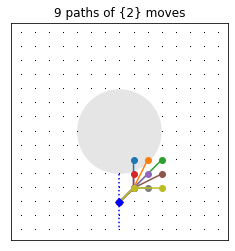

In [3]:
path = [start, Point(1, -4)]
paths = [path + [Point(path[-1] + velocity(path) + d)] 
         for d in deltas]
plot(paths)

# Navigating Regions

The goal of the race is to circumnavigate the center circle. I can describe that in a way that's generalizable to different tracks by saying that  `is_complete(path)` is true if the path enters  *regions* of points in a prescribed order. For our track a path is complete if it travels from the fourth [quadrant](https://mathworld.wolfram.com/Quadrant.html) to the first, second, third, and back to the fourth. A *region* is defined by a predicate that is true of any point in the region.

In [4]:
def Q1(p: Point) -> bool: "upper right quadrant"; return X(p) >= 0 and Y(p) >= 0
def Q2(p: Point) -> bool: "upper left  quadrant"; return X(p) <  0 and Y(p) >= 0
def Q3(p: Point) -> bool: "lower left  quadrant"; return X(p) <  0 and Y(p) <  0  
def Q4(p: Point) -> bool: "lower right quadrant"; return X(p) >= 0 and Y(p) <  0

circumnavigate = (Q4, Q1, Q2, Q3, Q4)
   
def is_complete(path, regions=circumnavigate) -> bool:
    """Does the path go through all the regions in the prescribed order?"""
    current = 0
    for p in path:
        if regions[current](p):
            current += 1
            if current == len(regions):
                return True
    return False

# Possible and Legal Moves

I'm thinking about how to solve for our specific track, and also how to make the code general enough that it could handle other tracks. I'll do that by splitting up responsibility:
- `possible_moves(path)` is general; it returns up to 9 points that are on the track and have the right velocity. 
- `legal_moves(path)` is specific; it won't cross into the center circle, and it won't pass from the fourth quadrant backwards into the third (while that is not technically illegal, it was causing problems, and no fast path should do that).

In [5]:
def possible_moves(path) -> List[Point]:
    """All moves with the right velocity that end up on the track."""
    p, v = path[-1], velocity(path)
    return {(p + v + Δ) for Δ in deltas} & track
                
def legal_moves(path) -> List[Point]:
    """What points can be reached in one step from this path?"""
    p = path[-1]
    return [p2 for p2 in possible_moves(path)
            if not (Q4(p) and Q3(p2)) # Don't go backwards over the finish line
            and not intersects_circle(p, p2)]

def intersects_circle(p: Point, p2: Point, radius=radius, N=20):
    """Are any of N+1 points on the line segment [p, p2] inside the circle's radius?"""
    linepoints = (p + (i / N) * (p2 - p) for i in range(N + 1))
    return any(abs(q) < radius for q in linepoints)

The math for solving for the intersection of a line segment and a circle looked [complicated](https://stackoverflow.com/questions/6091728/line-segment-circle-intersection), so instead I just define N+1 points along the line from point *p* to point *p2* and ask if any of those points is within the radius of the circle. If N is too small this could miss an intersection, but on the small grid for this race track, it shouldn't be a problem.

# A Frontier of Possible Paths

Now I want to expand paths by adding legal moves to the end until I find complete path(s). I could keep all my paths in a `list`, but there will be an exponential number of them (up to 9<sup><i>n<i/></sup> paths of length *n* and it looks like *n* will be around 10 to 13).

Instead I will keep track of a `frontier`, which I define as a mapping of `{(endpoint, velocity): path}`. The idea is that there may be many paths that arrive at the some endpoint with the same velocity in the same number of moves, but if so, the best continuation of all of them will be the same, so I only need to keep one of them. 

In [6]:
def expand(frontier) -> dict:
    """The {(endpoint, velocity): path} mapping extended one move in all legal ways."""
    return {(p, velocity([path[-1], p])): path + [p] 
            for path in frontier.values() 
            for p in legal_moves(path)}

I will show how the frontier expands over the first few steps:

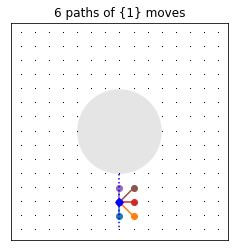

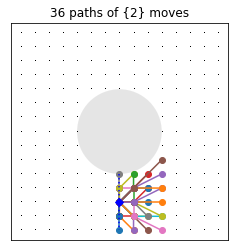

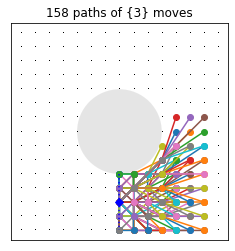

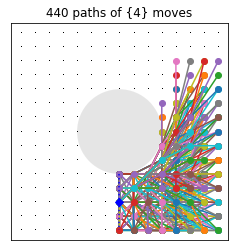

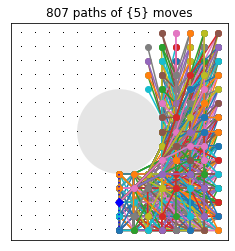

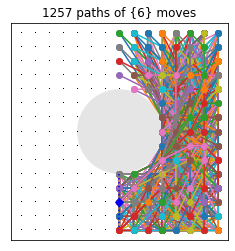

In [7]:
frontier = {(start, zero): [start]}

for i in range(6):
    frontier = expand(frontier)
    plot(frontier.values())
    plt.show()

(Note that the growth is much slower then 9<sup><i>n</i></sup>.)

# Searching for Fastest Complete Paths

Now all I have to do to solve the problem is repeatedly expand the frontier until some path(s) are complete. The first completed paths are guaranteed to be the fastest (i.e., have the fewest moves), because we are expanding one move at a time. In the end, I return a list of all the completed paths in the frontier, but there may be many other paths that are not returned, because I only kept one path for each `(endpoint, velocity)` pair along the way. 

In [8]:
def search(path=[start]) -> Path:
    """Find the shortest possible complete path(s)."""
    frontier = {(path[-1], velocity(path)): path}
    completed = []
    while not completed:
        frontier  = expand(frontier)
        completed = list(filter(is_complete, frontier.values()))
    return completed

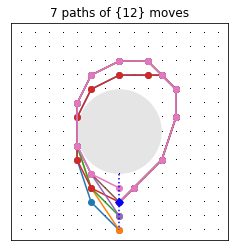

In [9]:
plot(search([start]))

We see that the fastest path takes 12 moves, and there are several ways to get there.

# Submitting your Answer

I'll need a bit of work to put my answers into the form requested by The Riddler:

> Finally, submitting your answer can be tricky work. Please be sure to submit both your total time, as well as your sequence of moves. Each move should be assigned a digit from 1 through 9, corresponding to the nine possible destinations of the move:
>
>     1 2 3
>     4 5 6
>     7 8 9

I will define two functions to translate back and forth between my path and The Riddler's list of digits: 

In [10]:
Digits = List[int]

def digits_from_path(path) -> Digits:
    """The digits that the path represents."""
    return [deltas.index(velocity(path[:i + 1]) - velocity(path[:i])) + 1
            for i in range(1, len(path))]

def path_from_digits(digits, start=start) -> Path:
    """The path that the digits represent."""
    velo = zero # Velocity
    path = [start]
    for d in digits:
        velo += deltas[d - 1]
        path.append(velo + path[-1])
    return path

In [11]:
for path in search([start]):
    digits = digits_from_path(path)
    assert path   == path_from_digits(digits_from_path(path))   # Inverses
    assert digits == digits_from_path(path_from_digits(digits)) # Inverses
    print(digits)

[3, 3, 1, 7, 7, 8, 4, 8, 9, 9, 6, 3]
[3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 6, 6]
[3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 6, 3]
[3, 3, 1, 7, 7, 8, 4, 8, 9, 9, 3, 3]
[3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 3, 9]
[3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 3, 6]
[3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 3, 3]


# Alternative Paths

Here we search from several different opening move sequences and get different results, but all of 12 moves:

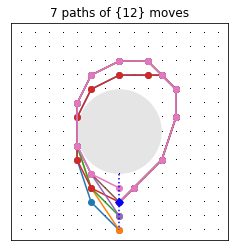

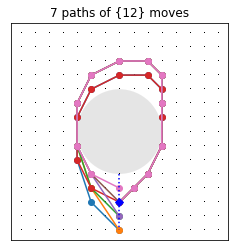

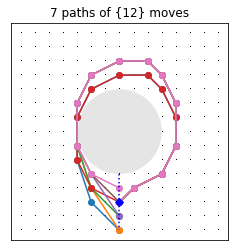

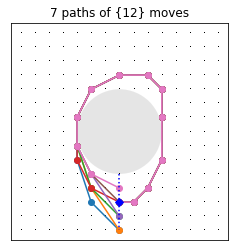

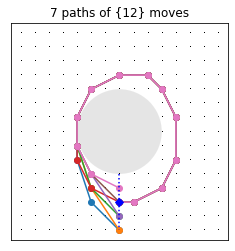

In [12]:
for opening in ([3, 3], [3, 5], [3, 6], [6, 2], [6, 3]):
    plot(search(path_from_digits(opening)))

# Tests

The code that I have the least confidence in is `intersects_circle`. Here are some tests and visualizations for it:

In [13]:
def test_intersects(expected: bool, segments: List[Path]):
    """Test if segments do the expected thing with `intersects_circle`."""
    plot(segments)
    for p, q in segments:
        assert intersects_circle(p, q) is expected

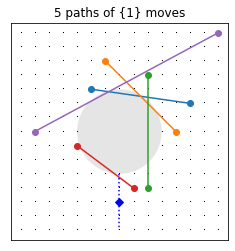

In [14]:
test_intersects(True, [ # Line segments that intersect the circle
    [Point(-2, 3), Point(5, 2)], 
    [Point(-1, 5), Point(4, 0)], 
    [Point(2, 4),  Point(2, -4)],
    [Point(-3, -1),Point(1, -4)],
    [Point(-6, 0), Point(7, 7)]])

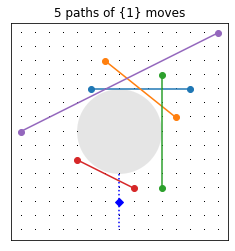

In [15]:
test_intersects(False, [ # Line segments that do not intersect the circle
    [Point(-2, 3), Point(5, 3)], 
    [Point(-1, 5), Point(4, 1)], 
    [Point(3, 4),  Point(3, -4)],
    [Point(-3, -2),Point(1, -4)],
    [Point(-7, 0), Point(7, 7)]])